In [1]:
# Import some libraries we'll need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as math
import scipy.sparse as sps
from scipy.sparse import csr_matrix

In [2]:
def read_review_data(file_name):
    review_data = pd.read_csv(file_name)
    print "Sample Data"
    print "-----------"
    print review_data.sample(5)
    return review_data

In [3]:
business_data = pd.read_csv('CSV/business.csv')
business_data.head(1)
business_data.set_index('business_id', inplace = True)

In [4]:
def get_restaurant_data(review_data, business_data):
    review_data['city'] = review_data.apply(lambda x: business_data.loc[x['business_id'], 'city'], axis=1)
    review_data['cat'] = review_data.apply(lambda x: business_data.loc[x['business_id'], 'categories'], axis=1)
    restaurant_reviews = review_data[review_data['cat'].str.contains("Restaurants",na=False)]
    return restaurant_reviews

In [5]:
def get_city_restaurant_data(city, restaurant_reviews):
    city_rest_data = restaurant_reviews.loc[review_data['city'] == city]
    return city_rest_data

In [14]:
def split_rating_matrix(rating_matrix, samples = 2):
    users, restaurants =  rating_matrix.nonzero()
    test = csr_matrix(rating_matrix.shape)
    train = rating_matrix.copy()

    num_users = rating_matrix.shape[0]
    for u in range(num_users):
        idx = restaurants[np.where(users == u)]
        np.random.shuffle(idx)
        test_idx = idx[-samples:]
        train_idx = idx[:-samples]
        test[u,test_idx] = rating_matrix[u,test_idx]
        train[u,test_idx] = 0

    data = np.array(train[train.nonzero()])[0]
    row = train.nonzero()[0]
    col = train.nonzero()[1]
    size = train.shape
    train = csr_matrix((data,(row,col)),shape = size)

    mult = train.multiply(test)
    assert(mult.nnz == 0)
    
    return train, test

In [15]:
def build_sparse_matrix(df):
    users = list(df['user_id'].unique())
    rests = list(df['business_id'].unique())
    data = df['stars'].tolist()
    row = df['user_id'].astype('category', categories=users).cat.codes
    col = df['business_id'].astype('category', categories=rests).cat.codes
    rating_matrix = csr_matrix((data, (row, col)), shape=(len(users), len(rests)))
    return rating_matrix

In [16]:
def split_train_test(df):
    '''Split for train and test data'''
    rating_matrix = build_sparse_matrix(df)
    train, test = split_rating_matrix(rating_matrix)
    num_train = train.shape[0]
    num_test = test.shape[0]
    
    print "Number of training samples: {}".format(num_train)
    print "Number of test samples: {}".format(num_test)
    
    return train, test

In [17]:
def get_rating_matrix(city_review_data):
    unique_users = city_review_data['user_id'].unique().tolist()
    unique_rests = city_review_data['business_id'].unique().tolist()
    num_user = len(unique_users)
    num_rest = len(unique_rests)

    print "Number of Users: {}".format(num_user)
    print "Number of Restaurent: {}".format(num_rest)
    
    train, test = split_train_test(city_review_data)
    return train, test

In [18]:
review_data = read_review_data('CSV/40core.csv')
print '-----------------------------'
print 'Filtering the Restaurant data'
print '-----------------------------'
restaurant_reviews = get_restaurant_data(review_data, business_data)
print restaurant_reviews.head(3)
print '-----------------------------'
print 'restaurant reviews top 10 cities'
print '-----------------------------'
print restaurant_reviews['city'].value_counts().head(10)
print '-----------------------------'
vegas_40 = get_city_restaurant_data('Las Vegas', restaurant_reviews)
vegas_40_train, vegas_40_test = get_rating_matrix(vegas_40)

Sample Data
-----------
                      user_id             business_id  stars
27712  f7Q14HePdG1vZpx28PpDRg  jScBTQtdAt-8RshaiBEHgw      4
55151  cBSYFg0yZ7ua5Fl_xcsfNQ  G-5kEa6E6PD5fkBRuA7k9Q      2
57509  bnk8hI3N5tprKm_lMK4I-w  VWtT4DKxQ4YVRWT88Z5SMA      5
19989  jUZW1alRK8QvdZ-pH1OquQ  HQcel0uvg7N7KfhHJChfSQ      4
12634  bLbSNkLggFnqwNNzzq-Ijw  N0apJkxIem2E8irTBRKnHw      3
-----------------------------
Filtering the Restaurant data
-----------------------------
                  user_id             business_id  stars       city  \
0  AuIK5tF2GjO7SftHawTLKw  I-5qHCVwT7k_KH67-YOx3A      4  Henderson   
2  AuIK5tF2GjO7SftHawTLKw  Zmfq3DVhHdtVChhSxzoUHw      4  Las Vegas   
3  AuIK5tF2GjO7SftHawTLKw  pybIuTluqRhH_BQ3CJHlLw      5  Las Vegas   

                                                 cat  
0  Desserts, Restaurants, American (Traditional),...  
2                                  Restaurants, Thai  
3                                  Thai, Restaurants  
---------------

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  """
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  
/anaconda2/lib/python2.7/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Number of training samples: 1355
Number of test samples: 1355


In [20]:
vegas_40_train

<1355x858 sparse matrix of type '<type 'numpy.int64'>'
	with 67778 stored elements in Compressed Sparse Row format>

In [43]:
def als(ratings_matrix, k=40, user_reg=0, res_reg=0, iters=10):
    ratings_matrix = ratings_matrix.T
    user_vec = np.random.rand(ratings_matrix.shape[1],k).T
    res_vec = np.random.rand(ratings_matrix.shape[0],k).T
    for i in range(iters):
        for u in range(ratings_matrix.shape[1]):
            user_vec[:,u] = np.linalg.solve(np.dot(res_vec,res_vec.T) + user_reg * np.eye(res_vec.shape[0]), np.dot(res_vec,ratings_matrix[:,u]))
        for r in range(ratings_matrix.shape[0]):
            res_vec[:,r] = np.linalg.solve(np.dot(user_vec,user_vec.T) + res_reg * np.eye(user_vec.shape[0]), np.dot(user_vec,ratings_matrix[r,:].T))
        prediction = np.dot(res_vec.T, user_vec)
    return np.dot(res_vec.T, user_vec).T

In [44]:
from sklearn.metrics import mean_absolute_error
def get_mae(pred, actual):
    # Ignore zero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_absolute_error(pred, actual)

In [ ]:
num_features = np.linspace(10,60,6,dtype=int)
test_error_als = []
train_error_als = []
for i in num_features:
    preds_als = als(np.array(vegas_40_train.todense()), k=i, iters = 5)
    test_err = get_mae(preds_als, np.array(vegas_40_test.todense()))
    test_error_als.append(test_err)

fig = plt.figure(figsize=(8,5))
plt.plot(num_features,test_error_als,'b-',label = 'test error')
plt.title('MAE vs num_features (for ALS)')
plt.xlabel('Number of features in a feature vector')
plt.ylabel('MAE')
plt.legend()

Text(0,0.5,'MSE')

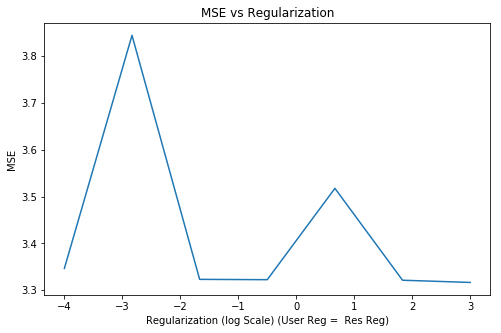

In [47]:
user_reg= np.logspace(-4,3,7)
val_error_als = {}
# train_error_als = {}
fig = plt.figure(figsize=(8,5))
for i in user_reg:
    val_error_als[i] = []
    preds_als = als(np.array(vegas_40_train.todense()),k=20, iters = 5, user_reg=i, res_reg=i)
    val_err = get_mae(preds_als, np.array(vegas_40_test.todense()))
    val_error_als[i].append(val_err)
plt.plot(np.log10(user_reg),val_error_als.values())
plt.title('MSE vs Regularization')
plt.xlabel('Regularization (log Scale) (User Reg =  Res Reg)')
plt.ylabel('MSE')